## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

## Import the data.  

While viewing the data with Data Wrangler I notice that the data column is not the appropriate type. Therefore, while importing I will change the InvoiceDate to type datetime64.

In [2]:
def clean_data(df):
    # Change column type to datetime64[ns] for column: 'InvoiceDate'
    df = df.astype({'InvoiceDate': 'datetime64[ns]'})
    # Split the InvoiceDate column into year, month, day, and hour columns
    return df

# Loaded Excel file into dataframe
df = pd.read_excel(r'Online Retail.xlsx')

df = clean_data(df.copy())
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


List the columns and store for future use

In [3]:
df_col = df.columns
df_col

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [4]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


From this describe it look as if there are order cancellations due to the negative values in the Quantity column. Also, there may be some errors in the pricing of some units as there are more negative values in UnitPrice.

Double check of Dtypes and also looking for null values

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


There are definitely some null, let's make it easier to see.  

In [6]:
df.isnull().any()

InvoiceNo      False
StockCode      False
Description     True
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID      True
Country        False
dtype: bool

I'm going to look to see if these missing values are distributed evenly.

<Axes: >

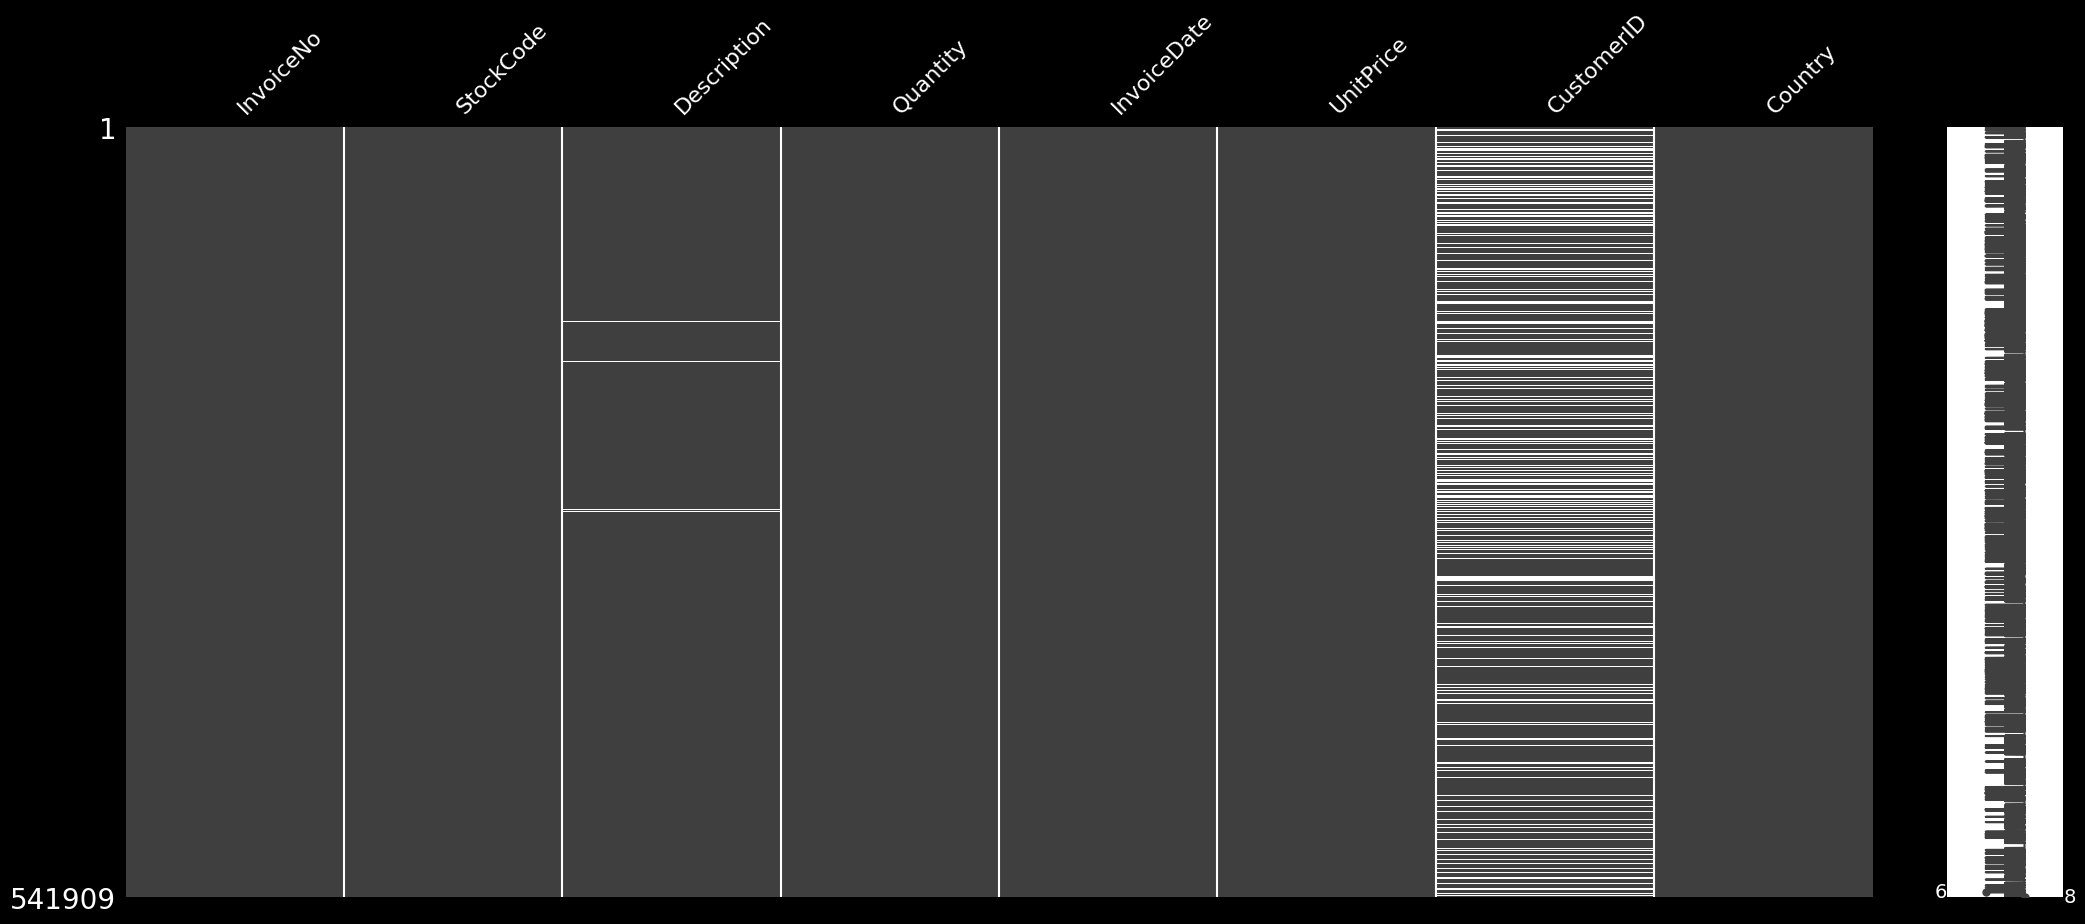

In [7]:
import missingno as msno
msno.matrix(df)

It appears that the missing CustomerID values are randomly distributed throughout the data. I'm going to separate it from the main data into a separate dataframe.

In [8]:
CustomerID_null = df[df['CustomerID'].isnull()]
CustomerID_null

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.79,NaN,United Kingdom


In [9]:
# export to csv for safe keeping
CustomerID_null.to_csv('CustomerID_null.csv', index=False)

In [10]:
# Drop rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [11]:
# recheck missing values
df.isnull().any()

InvoiceNo      False
StockCode      False
Description    False
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID     False
Country        False
dtype: bool

I noticed that CustomerID is stored as a float64. However, looks like CustomerID should be int32 as it's more of a category that a number.  

I will check to see if there are any numbers after the decimal. If not, then I will change the dtype.

In [12]:
fractions, _ = np.modf(df['CustomerID'])
has_decimal = fractions != 0
has_decimal.value_counts()

CustomerID
False    406829
Name: count, dtype: int64

In [13]:
df['CustomerID'] = df['CustomerID'].astype('int')
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France


Let's see where we now stand.

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  int32         
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(4)
memory usage: 26.4+ MB


In [15]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,406829.000000,406829,406829.000000,406829.000000
mean,12.061303,2011-07-10 16:30:57.879207424,3.460471,15287.690570
min,-80995.000000,2010-12-01 08:26:00,0.000000,12346.000000
25%,2.000000,2011-04-06 15:02:00,1.250000,13953.000000
50%,5.000000,2011-07-31 11:48:00,1.950000,15152.000000
75%,12.000000,2011-10-20 13:06:00,3.750000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,248.693370,NaN,69.315162,1713.600303


## Negative Values

### UnitPrice negative values disapeared with the removal of CustomerID NaN values.

### Quantity negative values

In [16]:
neg_quantity = df[df['Quantity'] < 0]
neg_quantity

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315,United Kingdom


I'm going to export this to a cvs file for safe keeping.

In [17]:
neg_quantity.to_csv('neg_quantity.csv', index=False)

In [18]:
df = df[df['Quantity'] >= 0]
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France


I noticed some product descriptions when I looked at the neg_quantity dataframe. Let's look at all the descriptions with 2 words and fewer.

In [19]:
des_small = df[df['Description'].str.count(' ') < 2]
look_des_small = des_small['Description'].value_counts()
look_des_small

Description
PARTY BUNTING                  1397
POSTAGE                        1099
SPOTTY BUNTING                 1017
POPCORN HOLDER                  657
CHILLI LIGHTS                   524
DOORMAT HEARTS                  484
Manual                          290
BINGO SET                       282
GRAND CHOCOLATECANDLE           251
PICTURE DOMINOES                250
POTTERING MUG                   200
DOORMAT TOPIARY                 183
PHOTO CUBE                      178
SPACEBOY BEAKER                 142
CARRIAGE                        133
RETROSPOT LAMP                  132
CHOCOLATE CALCULATOR            122
OWL DOORSTOP                    118
POLKADOT PEN                    107
HEART CALCULATOR                 96
SANDALWOOD FAN                   71
SOMBRERO                         59
MIRROR CORNICE                   55
BUTTERFLIES STICKERS             52
ANIMAL STICKERS                  47
POMPOM CURTAIN                   46
SKULLS TAPE                      41
CHRYSANTHEMUM NO

There seem to be a quite a few entries that are not products. I will remove and store them in a separate dataframe.

In [20]:
nonproducts = df[df['Description'].isin(['POSTAGE', 'Manual', 'Bank Charges', 'DOTCOM POSTAGE'])]
nonproducts

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.00,12583,France
386,536403,POST,POSTAGE,1,2010-12-01 11:27:00,15.00,12791,Netherlands
1123,536527,POST,POSTAGE,1,2010-12-01 13:04:00,18.00,12662,Germany
2239,536569,M,Manual,1,2010-12-01 15:35:00,1.25,16274,United Kingdom
2250,536569,M,Manual,1,2010-12-01 15:35:00,18.95,16274,United Kingdom
...,...,...,...,...,...,...,...,...
541198,581493,POST,POSTAGE,1,2011-12-09 10:10:00,15.00,12423,Belgium
541216,581494,POST,POSTAGE,2,2011-12-09 10:13:00,18.00,12518,Germany
541730,581570,POST,POSTAGE,1,2011-12-09 11:59:00,18.00,12662,Germany
541767,581574,POST,POSTAGE,2,2011-12-09 12:09:00,18.00,12526,Germany


In [21]:
nonproducts.to_csv('nonproducts.csv', index=False)

In [22]:
df = df[~df['Description'].isin(['POSTAGE', 'Manual', 'Bank Charges', 'DOTCOM POSTAGE'])]
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France


Let's see where we stand now.

In [23]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,396507.000000,396507,396507.000000,396507.000000
mean,13.042315,2011-07-11 00:05:00.353335808,2.883809,15301.362379
min,1.000000,2010-12-01 08:26:00,0.000000,12346.000000
25%,2.000000,2011-04-07 11:16:00,1.250000,13975.000000
50%,6.000000,2011-07-31 14:39:00,1.950000,15159.000000
75%,12.000000,2011-10-20 14:41:00,3.750000,16801.000000
max,80995.000000,2011-12-09 12:50:00,649.500000,18287.000000
std,180.702510,NaN,4.354358,1709.787555


It looks like there are some extreme outliers. I will take a look at them.

In [24]:
df_q_outlier = df[df['Quantity'] > 100]
df_q_outlier

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
96,536378,21212,PACK OF 72 RETROSPOT CAKE CASES,120,2010-12-01 09:37:00,0.42,14688,United Kingdom
178,536387,79321,CHILLI LIGHTS,192,2010-12-01 09:58:00,3.82,16029,United Kingdom
179,536387,22780,LIGHT GARLAND BUTTERFILES PINK,192,2010-12-01 09:58:00,3.37,16029,United Kingdom
180,536387,22779,WOODEN OWLS LIGHT GARLAND,192,2010-12-01 09:58:00,3.37,16029,United Kingdom
181,536387,22466,FAIRY TALE COTTAGE NIGHTLIGHT,432,2010-12-01 09:58:00,1.45,16029,United Kingdom
...,...,...,...,...,...,...,...,...
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom
540442,581487,21137,BLACK RECORD COVER FRAME,120,2011-12-09 09:44:00,3.39,15694,United Kingdom
541545,581501,22319,HAIRCLIPS FORTIES FABRIC ASSORTED,180,2011-12-09 10:46:00,0.19,12985,United Kingdom
541702,581566,23404,HOME SWEET HOME BLACKBOARD,144,2011-12-09 11:50:00,3.26,18102,United Kingdom


I will now compare this dataframe to the neg_quantity dataframe for possible canceled orders.

In [25]:
neg_quantity['Quantity'] = neg_quantity['Quantity'].abs()

df_q_outlier['MATCH'] = (df_q_outlier['StockCode'].isin(neg_quantity['StockCode']) &
                        df_q_outlier['Quantity'].isin(neg_quantity['Quantity']))

df_q_outlier


C:\Users\nino\AppData\Local\Temp\ipykernel_29464\536529373.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_quantity['Quantity'] = neg_quantity['Quantity'].abs()
C:\Users\nino\AppData\Local\Temp\ipykernel_29464\536529373.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_q_outlier['MATCH'] = (df_q_outlier['StockCode'].isin(neg_quantity['StockCode']) &


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,MATCH
96,536378,21212,PACK OF 72 RETROSPOT CAKE CASES,120,2010-12-01 09:37:00,0.42,14688,United Kingdom,True
178,536387,79321,CHILLI LIGHTS,192,2010-12-01 09:58:00,3.82,16029,United Kingdom,True
179,536387,22780,LIGHT GARLAND BUTTERFILES PINK,192,2010-12-01 09:58:00,3.37,16029,United Kingdom,True
180,536387,22779,WOODEN OWLS LIGHT GARLAND,192,2010-12-01 09:58:00,3.37,16029,United Kingdom,True
181,536387,22466,FAIRY TALE COTTAGE NIGHTLIGHT,432,2010-12-01 09:58:00,1.45,16029,United Kingdom,True
...,...,...,...,...,...,...,...,...,...
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom,True
540442,581487,21137,BLACK RECORD COVER FRAME,120,2011-12-09 09:44:00,3.39,15694,United Kingdom,True
541545,581501,22319,HAIRCLIPS FORTIES FABRIC ASSORTED,180,2011-12-09 10:46:00,0.19,12985,United Kingdom,True
541702,581566,23404,HOME SWEET HOME BLACKBOARD,144,2011-12-09 11:50:00,3.26,18102,United Kingdom,True


In [26]:
cancelled_orders = df_q_outlier[df_q_outlier['MATCH']]

cancelled_orders = cancelled_orders.drop('MATCH', axis=1)

cancelled_orders

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
96,536378,21212,PACK OF 72 RETROSPOT CAKE CASES,120,2010-12-01 09:37:00,0.42,14688,United Kingdom
178,536387,79321,CHILLI LIGHTS,192,2010-12-01 09:58:00,3.82,16029,United Kingdom
179,536387,22780,LIGHT GARLAND BUTTERFILES PINK,192,2010-12-01 09:58:00,3.37,16029,United Kingdom
180,536387,22779,WOODEN OWLS LIGHT GARLAND,192,2010-12-01 09:58:00,3.37,16029,United Kingdom
181,536387,22466,FAIRY TALE COTTAGE NIGHTLIGHT,432,2010-12-01 09:58:00,1.45,16029,United Kingdom
...,...,...,...,...,...,...,...,...
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom
540442,581487,21137,BLACK RECORD COVER FRAME,120,2011-12-09 09:44:00,3.39,15694,United Kingdom
541545,581501,22319,HAIRCLIPS FORTIES FABRIC ASSORTED,180,2011-12-09 10:46:00,0.19,12985,United Kingdom
541702,581566,23404,HOME SWEET HOME BLACKBOARD,144,2011-12-09 11:50:00,3.26,18102,United Kingdom


In [27]:
df = df.drop(cancelled_orders.index)

In [28]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,393058.000000,393058,393058.00000,393058.000000
mean,10.755285,2011-07-11 02:13:21.196566528,2.89716,15301.648136
min,1.000000,2010-12-01 08:26:00,0.00000,12347.000000
25%,2.000000,2011-04-07 11:29:00,1.25000,13975.000000
50%,5.000000,2011-07-31 15:00:00,1.95000,15159.000000
75%,12.000000,2011-10-20 15:57:00,3.75000,16803.000000
max,12540.000000,2011-12-09 12:50:00,649.50000,18287.000000
std,39.265153,NaN,4.36928,1709.234958


It seems we've knocked out a good portion of outliers as cancelled orders. But there is still a large quantity order remaining. I will see if that order was in the df_q_outlier dataframe and if it was a cancelled order.

In [29]:
print(df_q_outlier[df_q_outlier['Quantity'] == 12540])

       InvoiceNo StockCode                     Description  Quantity  \
502122    578841     84826  ASSTD DESIGN 3D PAPER STICKERS     12540   

               InvoiceDate  UnitPrice  CustomerID         Country  MATCH  
502122 2011-11-25 15:57:00        0.0       13256  United Kingdom  False  


Interesting, a price of 0.0. Maybe it was a free giveaway. Or a pricing error that was exploited.

It appears that UnitPrice seems reasonable now that we've filtered out non-products and cancelled orders. But let's take a look.

In [30]:
df_u_outlier = df[df['UnitPrice'] > 100]
df_u_outlier

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
246,536392,22827,RUSTIC SEVENTEEN DRAWER SIDEBOARD,1,2010-12-01 10:29:00,165.0,13705,United Kingdom
4989,536835,22655,VINTAGE RED KITCHEN CABINET,1,2010-12-02 18:06:00,295.0,13145,United Kingdom
19428,537859,22828,REGENCY MIRROR WITH SHUTTERS,1,2010-12-08 16:11:00,165.0,14030,United Kingdom
19429,537859,22827,RUSTIC SEVENTEEN DRAWER SIDEBOARD,2,2010-12-08 16:11:00,145.0,14030,United Kingdom
25168,538354,22826,LOVE SEAT ANTIQUE WHITE METAL,2,2010-12-10 15:45:00,175.0,16873,United Kingdom
...,...,...,...,...,...,...,...,...
433190,573905,22655,VINTAGE RED KITCHEN CABINET,1,2011-11-01 15:06:00,125.0,16971,United Kingdom
443596,574705,22827,RUSTIC SEVENTEEN DRAWER SIDEBOARD,1,2011-11-06 14:06:00,165.0,14553,United Kingdom
468546,576512,22823,CHEST NATURAL WOOD 20 DRAWERS,4,2011-11-15 12:09:00,110.0,15524,United Kingdom
471340,576635,22828,REGENCY MIRROR WITH SHUTTERS,2,2011-11-16 09:32:00,145.0,15269,United Kingdom


# This is the end of the cleaning portion. 
### I'll export the result to be used in further analysis and models.

In [31]:
df.to_csv('data_cleaned.csv', index=False)